# NLIP. Home assignment 3.                                  Zhanna Azizova

**The task**
- Classify news to one of 5 categories based on text

1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline
3. Tune  your model;

In [18]:
# load libraries

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy
import nltk
import os
import re
import glob
import multiprocessing
import time
import keras
import itertools

import sklearn.metrics as metrics

from keras.backend import floatx
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_folder = "/Users/zhannaazizova/Desktop/bbc"
folders = ["business","entertainment","politics","sport","tech"]

os.chdir(data_folder)

x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" +text_file
        with open(file_path,encoding='utf-8', errors='ignore') as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)
 
df = {'text': x, 'category': y}       
data = pd.DataFrame(df)
#print ('writing csv flie ...')
data.to_csv('../dataset.csv', index=False)

In [4]:
def plot_confusion_matrix(Y_test, y_pred, classes, title):
    cm = confusion_matrix(y_test,y_pred)
    np.set_printoptions(precision=2)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
data.head()

,category,text
0,business,UK economy facing 'major risks'\n \n The UK ma...
1,business,Aids and climate top Davos agenda\n \n Climate...
2,business,Asian quake hits European shares\n \n Shares i...
3,business,India power shares jump on debut\n \n Shares i...
4,business,Lacroix label bought by US firm\n \n Luxury go...


In [6]:
data['category'].value_counts() #classes are not perfectly equal but disproportionality is not as huge 

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [7]:
data['target'] = pd.Categorical(data['category']).codes

In [8]:
data[['target','category']].groupby(['target','category']).count()

,
target,category
0,business
1,entertainment
2,politics
3,sport
4,tech


## Metric for quality


If choosing the only one, the best choices as metrics for quality evaluation for multiclass classification models is: ** f1 score**. F1-score takes into account both recall and precsision that means that it evaluates how well model distinguishes between all classes.

F1 Score: It is a harmonic mean of precision and recall given by- 
F1 = 2*Precision*Recall/(Precision + Recall).

Since classes are more or less balanced we can choose macro average f1-score.

## Data processing and feature extraction 

In [9]:
stop_words = set(stopwords.words('english'))
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize(document, rebuild_document=True):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [wordnet_lemmatizer.lemmatize(t.lower().strip("'")) 
                  for t in regexp_tokenizer.tokenize(sentence) if t.lower() not in stop_words]
        words += tokens

    if rebuild_document:
        return ' '.join(words).strip()
    else:
        return words

In [27]:
data['toc_text'] = data['text'].apply(tokenize)

In [11]:
data.head()

,category,text,target,toc_text
0,business,UK economy facing 'major risks'\n \n The UK ma...,0,uk economy facing major risk uk manufacturing ...
1,business,Aids and climate top Davos agenda\n \n Climate...,0,aid climate top davos agenda climate change fi...
2,business,Asian quake hits European shares\n \n Shares i...,0,asian quake hit european share share europe's ...
3,business,India power shares jump on debut\n \n Shares i...,0,india power share jump debut share india's lar...
4,business,Lacroix label bought by US firm\n \n Luxury go...,0,lacroix label bought u firm luxury good group ...


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['toc_text'], data['target'], random_state=42)

In [18]:
max_words = 1000
batch_size = 32
epochs = 5

In [19]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [20]:
x_train_bin = tokenizer.texts_to_matrix(X_train, mode='binary')
x_test_bin = tokenizer.texts_to_matrix(X_test, mode='binary')
print('x_train shape:', x_train_bin.shape)
print('x_test shape:', x_test_bin.shape)

x_train shape: (1668, 1000)
x_test shape: (557, 1000)


In [21]:
# Convert class vector to binary class matrix for use with categorical_crossentropy
num_classes = 5

y_train_bin = keras.utils.to_categorical(y_train, num_classes)
y_test_bin = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train_bin.shape)
print('y_test shape:', y_test_bin.shape)

y_train shape: (1668, 5)
y_test shape: (557, 5)


# Pipeline building, modeling, model evaluation and tuning

## Keras ANN

In [22]:
# Building Keras model 
model = Sequential([
          Dense(512, input_shape=(max_words,)),
          Activation('relu'),
          Dropout(0.5),
          Dense(num_classes),
          Activation('softmax')])

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
history = model.fit(x_train_bin, y_train_bin,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1501 samples, validate on 167 samples
Epoch 1/5
1501/1501 [==============================] - 3s 2ms/step - loss: 0.6245 - acc: 0.8208 - val_loss: 0.1341 - val_acc: 0.9760
Epoch 2/5
1501/1501 [==============================] - 1s 475us/step - loss: 0.0894 - acc: 0.9847 - val_loss: 0.0869 - val_acc: 0.9760
Epoch 3/5
1501/1501 [==============================] - 1s 499us/step - loss: 0.0371 - acc: 0.9960 - val_loss: 0.0669 - val_acc: 0.9940
Epoch 4/5
1501/1501 [==============================] - 1s 477us/step - loss: 0.0198 - acc: 0.9993 - val_loss: 0.0583 - val_acc: 0.9820
Epoch 5/5
1501/1501 [==============================] - 1s 484us/step - loss: 0.0127 - acc: 0.9993 - val_loss: 0.0591 - val_acc: 0.9820


In [25]:
score = model.evaluate(x_test_bin, y_test_bin,
                       batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

557/557 [==============================] - 0s 114us/step


Test score: 0.11869349936608566
Test accuracy: 0.9587073609687695


In [26]:
y_pred = model.predict_classes(tokenizer.texts_to_matrix(X_test, mode='binary'), batch_size=batch_size, verbose=1)

557/557 [==============================] - 0s 261us/step


In [27]:
labels = ['business','entertainment','politics','sport','tech']
print(classification_report(y_test, y_pred, target_names = labels))

               precision    recall  f1-score   support

     business       0.97      0.94      0.96       142
entertainment       0.97      0.95      0.96        94
     politics       0.87      0.98      0.92        95
        sport       0.98      0.99      0.99       122
         tech       1.00      0.93      0.97       104

    micro avg       0.96      0.96      0.96       557
    macro avg       0.96      0.96      0.96       557
 weighted avg       0.96      0.96      0.96       557



## Naive Bayes approach

### Multinomial with Count Vectorizer

In [28]:
count_vectorizer = CountVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_cv_nb_pipeline = Pipeline([('vectorizer', count_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_cv_nb_param_grid = [
    {   'vectorizer__min_df': [ 1, 2, 3],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3) ],
        'multinomial_nb__alpha': [ 0.0, 0.25, 0.5]}]

In [29]:
# Perform grid search
mn_cv_nb_gs = GridSearchCV(estimator=mn_cv_nb_pipeline, param_grid=mn_cv_nb_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=multiprocessing.cpu_count())
mn_cv_nb_gs.fit(X_train, y_train)

# Create an instance of the best estimator
mn_cv_nb_best = mn_cv_nb_gs.best_estimator_
mn_cv_nb_best.fit(X_train, y_train)

print('Best model: %s' % str(mn_cv_nb_gs.best_params_))
print('Best f1 score: %f' % mn_cv_nb_gs.best_score_)
print('Best test f1 score: %f' % mn_cv_nb_best.score(X_test, y_test))

Best model: {'multinomial_nb__alpha': 0.25, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 3)}
Best f1 score: 0.979299
Best test f1 score: 0.978456


In [30]:
mn_cv_nb_Y_pred = mn_cv_nb_best.predict(X_test)
print(classification_report(y_test, mn_cv_nb_Y_pred, target_names = labels))

               precision    recall  f1-score   support

     business       0.99      0.96      0.98       142
entertainment       0.98      0.97      0.97        94
     politics       0.93      0.99      0.96        95
        sport       1.00      1.00      1.00       122
         tech       0.99      0.97      0.98       104

    micro avg       0.98      0.98      0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



### Multinomial with Tf-Idf Vectorizer

In [38]:
tfidf_vectorizer = TfidfVectorizer()
multinomialNB = MultinomialNB()

# Define pipeline
mn_tfidfv_nb_pipeline = Pipeline([('vectorizer', tfidf_vectorizer),
                             ('multinomial_nb', multinomialNB)])

# Grid search parameters
mn_tfidfv_nb_param_grid = [
    {   'vectorizer__min_df': [ 1, 2, 3],
        'vectorizer__ngram_range': [ (1, 1), (1, 2), (1, 3)],
        'vectorizer__norm': [ None, 'l1', 'l2' ],
        'multinomial_nb__alpha': [0.25, 0.5]}]

# Perform grid search
mn_tfidfv_nb_gs = GridSearchCV(estimator=mn_tfidfv_nb_pipeline, param_grid=mn_tfidfv_nb_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=multiprocessing.cpu_count())
mn_tfidfv_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...  vocabulary=None)), ('multinomial_nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'vectorizer__min_df': [1, 2, 3], 'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vectorizer__norm': [None, 'l1', 'l2'], 'multinomial_nb__alpha': [0.25, 0.5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [39]:
# Create an instance of the best estimator
mn_tfidfv_nb_best = mn_tfidfv_nb_gs.best_estimator_
mn_tfidfv_nb_best.fit(X_train, y_train)

print('Best model: %s' % str(mn_tfidfv_nb_gs.best_params_))
print('Best f1 score: %f' % mn_tfidfv_nb_gs.best_score_)
print('Best test f1 score: %f' % mn_tfidfv_nb_best.score(X_test, y_test))

Best model: {'multinomial_nb__alpha': 0.25, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': None}
Best f1 score: 0.977870
Best test f1 score: 0.982047


In [64]:
mn_tfidfv_nb_gs.fit(X_train, y_train)
mn_tfidfv_nb_pred = mn_tfidfv_nb_gs.predict(X_test)
print(classification_report(y_test, mn_tfidfv_nb_pred, target_names = labels))

               precision    recall  f1-score   support

     business       0.99      0.96      0.98       142
entertainment       0.99      0.98      0.98        94
     politics       0.94      1.00      0.97        95
        sport       1.00      1.00      1.00       122
         tech       0.98      0.97      0.98       104

    micro avg       0.98      0.98      0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



## Doc2Vec (Gensim-based) approach


In [33]:
# Create tagged documents
bbc_news_tagged_documents = []
bbc_news_X = data['toc_text']
bbc_news_Y = data['target']

for i, document in enumerate(bbc_news_X):
    bbc_news_tagged_documents.append(TaggedDocument(document.split(' '), [i]))
    

In [36]:
# Train Doc2Vec
doc2vec_vector_size = 50
doc2vec_model = Doc2Vec(documents=bbc_news_tagged_documents, size=doc2vec_vector_size, window=3, 
                        min_count=2, iter=30, workers=multiprocessing.cpu_count())
doc2vec_model.init_sims(replace=False)

# Vectorize documents and split the whole corpus in train and test sets
bbc_news_vectors = []

for document in bbc_news_X:
    bbc_news_vectors.append(doc2vec_model.infer_vector(document.split(' ')))

In [42]:
d2v_X_train, d2v_X_test, d2v_Y_train, d2v_Y_test = train_test_split(bbc_news_vectors, bbc_news_Y, test_size=0.3)

## Support Vector Machines (Linear and Kernel-based)


In [39]:
scaler = StandardScaler()
svc = SVC()

# Define pipeline
svc_d2v_pipeline = Pipeline([('scaler', scaler),
                             ('svc', svc)])

# Grid search parameters
svc_d2v_param_grid = [ {   'svc__kernel': [ 'linear', 'rbf'],
                           'svc__C': [0.5, 1.0] }]

# Perform grid search
svc_d2v_gs = GridSearchCV(estimator=svc_d2v_pipeline, param_grid=svc_d2v_param_grid, 
                           scoring='f1_macro', cv=3, n_jobs=multiprocessing.cpu_count())

svc_d2v_gs.fit(d2v_X_train, d2v_Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'svc__kernel': ['linear', 'rbf'], 'svc__C': [0.5, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [46]:
# Create an instance of the best estimator
svc_d2v_best = svc_d2v_gs.best_estimator_
svc_d2v_best.fit(d2v_X_train, d2v_Y_train)

print('Best model: %s' % str(svc_d2v_gs.best_params_))
print('Best score: %f' % svc_d2v_gs.best_score_)

Best model: {'svc__C': 1.0, 'svc__kernel': 'rbf'}
Best score: 0.949955


In [52]:
svc_d2v_Y_pred = svc_d2v_best.predict(d2v_X_test)
print(classification_report(d2v_Y_test, svc_d2v_Y_pred, target_names = labels))

               precision    recall  f1-score   support

     business       0.92      0.98      0.95       143
entertainment       0.97      0.97      0.97       122
     politics       0.97      0.89      0.93       120
        sport       0.99      0.99      0.99       161
         tech       0.95      0.96      0.96       122

    micro avg       0.96      0.96      0.96       668
    macro avg       0.96      0.96      0.96       668
 weighted avg       0.96      0.96      0.96       668



## Conclusion

**Multinomial NB with Tf-Idf Vectorizer with the following parameters**

'multinomial_nb__alpha': 0.25, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': None

**turned out to be the best model pipeline for bbc news classification with F1-score.**

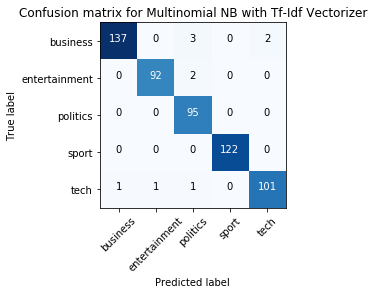

In [66]:
plot_confusion_matrix(y_test, mn_tfidfv_nb_pred, labels, 'Confusion matrix for Multinomial NB with Tf-Idf Vectorizer')